# Before running:
Make sure the edited code for EGG is included in your files, as well as the folders called "data" and "models" in the same folder. We expect the code to be run in google colab, so the following steps should help you set up the right imports.

Please edit the next two cells if necessary. The content of these cells may require slight changes.

In [4]:
# instead of installing egg we downloaded the source code
# in order to be able to edit it
# and load the code with google
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
# move working dir to where egg source code is located
# EDIT THIS:
%cd "/content/drive/My Drive/AI/NLP2 (shared)/Code"
# %cd "drive/My Drive/Education/Master Data Science/Master/Semester 1/NLP2/NLP2 (shared)"

# "EGG" should be in the following list, as well as "data"
!ls

/content/drive/My Drive/AI/NLP2 (shared)/Code
data  EGG  models  Notebook.ipynb


In [0]:
import os, sys, torch, random, pickle, json, matplotlib

import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from EGG.egg.core import *
opts = init(params=[])

from data.customData import CustomDataset
import data.utils as utils

In [7]:
#generate or load the datasets
#see "data" for the implementation of CustomDataset and utils
torch.manual_seed(0)

overwrite = False
if not os.path.exists("data/pretrain_loader") or overwrite:
  batch_size = 64
  test_size = 2000
  
  pretrain_data = CustomDataset("square", size=28, num_samples=2000, dynamic=True)
  train6_static = CustomDataset("square", size=28, num_samples=10000, dynamic=False, distractors=6)
  test6_data = CustomDataset("square", size=28, num_samples=test_size, dynamic=False, distractors=6)
  
  pretrain_loader = DataLoader(pretrain_data, batch_size=batch_size, shuffle=True)
  static6_loader = DataLoader(train6_static, batch_size=batch_size, shuffle=True)
  test6_loader = DataLoader(test6_data, batch_size=test_size, shuffle=False)

  with open("data/pretrain_loader", 'wb') as f:
    pickle.dump(pretrain_loader, f)
  with open("data/static6_loader", 'wb') as f:
    pickle.dump(static6_loader, f)
  with open("data/test6_loader", 'wb') as f:
    pickle.dump(test6_loader, f)
else:
  print("Loading from disk...")

  with open("data/pretrain_loader", 'rb') as f:
    pretrain_loader = pickle.load(f)
  with open("data/static6_loader", 'rb') as f:
    static6_loader = pickle.load(f)
  with open("data/test6_loader", 'rb') as f:
    test6_loader = pickle.load(f)

Loading from disk...


squares


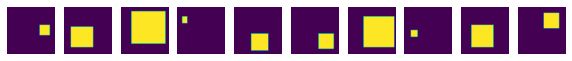

circles


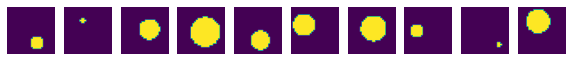

In [8]:
# this is how our data looks like
# for our work we focused on squares
# it would be interesting to extend this to multiple shapes
data = {}
data["squares"], _ = utils.generate_data(num_samples=10, shape="square")
data["circles"], _ = utils.generate_data(num_samples=10, shape="circle")
for shape in data:
  print(shape)
  plt.figure(figsize=(10,1)) 
  for n in range(data[shape].size(0)):
    plt.subplot(1,10,n+1) 
    plt.axis("off")
    plt.imshow(data[shape][n].squeeze())
  plt.show()

In [0]:
def atts2classes(target_atts, ref_atts, specific=True):
  # class 0 true if target[0] > ref[0]
  # class 1 true if target[0] < ref[0]
  # class 2 true if target[1] > ref[1]
  # class 3 true if target[1] < ref[1]
  # class 4 true if target[2] > ref[2]
  # class 5 true if target[2] < ref[2]

  classes = torch.zeros(target_atts.size(0), dtype=int)
  if specific:
    classes[target_atts[:,0] > ref_atts[:,0]] = 0 # "more to the right"
    classes[target_atts[:,0] < ref_atts[:,0]] = 1 # "more to the left"
    classes[target_atts[:,1] > ref_atts[:,1]] = 2 # "further up"
    classes[target_atts[:,1] < ref_atts[:,1]] = 3 # "further down"
    classes[target_atts[:,2] > ref_atts[:,2]] = 4 # "scale up" / "larger"
    classes[target_atts[:,2] < ref_atts[:,2]] = 5 # "scale down" / "smaller"
  else:
    classes[target_atts[:,0] != ref_atts[:,0]] = 0 # "x change"
    classes[target_atts[:,1] != ref_atts[:,1]] = 1 # "y change"
    classes[target_atts[:,2] != ref_atts[:,2]] = 2 # "size change"

  return classes

In [0]:
class Vision(nn.Module):
    def __init__(self):
        super(Vision, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 32)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        return x

class PretrainNet(nn.Module):
    def __init__(self, vision_module, output_size):
        super(PretrainNet, self).__init__()
        self.vision_module = vision_module
        self.fc = nn.Linear(32*2, output_size)
        
    def forward(self, x1, x2):
        x1 = self.vision_module(x1)
        x2 = self.vision_module(x2)
        x = self.fc(F.leaky_relu(torch.cat((x1,x2),1)))
        return x

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
#pretrain vision module to recognize attribute changes with direction (larger / smaller)
torch.manual_seed(0)

visionAtt_path = "models/pretrainedAtt_vision_check.pt"

overwrite = True
if not os.path.exists(visionAtt_path) or overwrite:
  vision = Vision()
  model = PretrainNet(vision, output_size=6).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 
  for epoch in range(20):
    mean_loss, n_batches, accuracy = 0, 0, 0
    for batch_idx, (data, target, _, _) in enumerate(pretrain_loader):
        data, target = data.to(device), target.to(device)
        altered = utils.alter_attributes("square", target)
        reference = utils.reconstruct("square", altered).to(device)
        t = atts2classes(target, altered).to(device)
        optimizer.zero_grad()
        output = model(data, reference)
        loss = criterion(output, t)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
          accuracy += torch.sum(torch.argmax(output,1) == t).item()/float(data.size(0))

        mean_loss += loss.mean().item()
        n_batches += 1
        
    print(f'Train Epoch: {epoch}, mean loss: {mean_loss / n_batches}, accuracy: {accuracy / n_batches}')
  torch.save(vision, visionAtt_path)
else:
  print("Att vision module already trained")

Train Epoch: 0, mean loss: 1.5532367564737797, accuracy: 0.3818359375
Train Epoch: 1, mean loss: 0.9227197598665953, accuracy: 0.6318359375
Train Epoch: 2, mean loss: 0.659533990547061, accuracy: 0.75341796875
Train Epoch: 3, mean loss: 0.6269098715856671, accuracy: 0.77197265625
Train Epoch: 4, mean loss: 0.6071618990972638, accuracy: 0.7841796875
Train Epoch: 5, mean loss: 0.5301675368100405, accuracy: 0.8134765625
Train Epoch: 6, mean loss: 0.4525434938259423, accuracy: 0.8408203125
Train Epoch: 7, mean loss: 0.4139099661260843, accuracy: 0.857421875
Train Epoch: 8, mean loss: 0.45189090352505445, accuracy: 0.84130859375
Train Epoch: 9, mean loss: 0.3667931684758514, accuracy: 0.873046875
Train Epoch: 10, mean loss: 0.38960727537050843, accuracy: 0.86572265625
Train Epoch: 11, mean loss: 0.3808424323797226, accuracy: 0.86328125
Train Epoch: 12, mean loss: 0.40069704921916127, accuracy: 0.86669921875
Train Epoch: 13, mean loss: 0.3233532886952162, accuracy: 0.88427734375
Train Epoch:

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Vision. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
class Sender(nn.Module):
  def __init__(self, vision, output_size):
    super(Sender, self).__init__()
    self.fc = nn.Linear(32*2, output_size)
    self.vision = vision
     
class BasicSender(Sender):
  # takes as input tuple x containing target and reference
  def forward(self, x):
    x = self.vision(torch.cat(x, 0))
    x = torch.cat(torch.chunk(x,2),1)
    x = self.fc(x)
    return x

class TrainedSender(Sender):
  # takes as input tuple x containing target and reference
  def forward(self, x):
    with torch.no_grad():
      x = self.vision(torch.cat(x, 0))
    x = torch.cat(torch.chunk(x,2),1)
    x =  self.fc(x)
    return x

class Receiver(nn.Module):
  def __init__(self, vision, input_size):
    super(Receiver, self).__init__()
    self.fc = nn.Linear(input_size+32, 32)
    self.vision = vision

class BasicReceiver(Receiver):
  # takes as input channel_input = message and receiver_input = reference
  def forward(self, channel_input, receiver_input):
    x = self.vision(receiver_input)
    x = torch.cat((channel_input, x), 1)
    x = torch.tanh(self.fc(x))
    return x
      
class TrainedReceiver(Receiver):
  # takes as input channel_input = message and receiver_input = reference
  def forward(self, channel_input, receiver_input):
    with torch.no_grad():
      x = self.vision(receiver_input)
    x = torch.cat((channel_input, x), 1)
    x = torch.tanh(self.fc(x))
    return x

In [0]:
def loss(sender_input, _message, _receiver_input, receiver_output, labels):
  # calculates cross entropy loss for negative MSEs between message+reference representation and
  # target and distractors representations. result: message+reference representation get closer to target repr
  prediction = torch.zeros((receiver_output.size(0), labels[1].size(1)+1),device=device)
  prediction[:,0] = torch.mean(F.mse_loss(receiver_output, labels[0],reduction="none"),1)
  for i in range(labels[1].size(1)):
    prediction[:,i+1] = torch.mean(F.mse_loss(receiver_output, labels[1][:,i,:],reduction="none"),1)
  loss = F.cross_entropy(-prediction, torch.zeros(receiver_output.size(0),dtype=int,device=device))
  return loss, {}

In [0]:
vocab_size = 4
max_len = 3

hidden_size = 20
emb_size = 10

In [16]:
# train baseline game (without reference image)
# in this case the reference image is simply set to a bunch of zeros 
# see edited EGG code for more details on implementation

# seeds = [2,1,0] #used for testing
seeds = [0]
accuracies = []

for seed in seeds:
  torch.manual_seed(seed)

  gameBaseline_path = "models/baseline_game6_check.pt"

  overwrite = True
  if not os.path.exists(gameBaseline_path) or overwrite:

    senderVision = Vision()
    receiverVision = Vision()

    sender = BasicSender(senderVision, hidden_size)
    receiver = BasicReceiver(receiverVision, hidden_size)

    sender_rnn = RnnSenderGS(sender, vocab_size, emb_size, hidden_size,
                                      cell="gru", max_len=max_len, temperature=0.2)
    receiver_rnn = RnnReceiverGS(receiver, vocab_size, emb_size,
                        hidden_size, cell="gru")
    game_rnn = SenderReceiverRnnGS(sender_rnn, receiver_rnn, loss, device, baseline=True)

    optimizer = torch.optim.Adam(game_rnn.parameters(), lr=2e-4)
    trainer = Trainer(game=game_rnn, optimizer=optimizer, 
                      train_data=static6_loader,
                      validation_data=test6_loader, 
                      callbacks=[ConsoleLogger(print_train_loss=True)])
    trainer.train(40)
    torch.save(game_rnn, gameBaseline_path)
    accuracies.append(trainer.eval(return_acc=True)[2].item())
  else:
    print("Baseline game already trained")
if not os.path.exists(gameBaseline_path) or overwrite:
  print(np.mean(accuracies), np.std(accuracies))

train: epoch 1, loss 1.9334007501602173,  {'mean_length': tensor(2.8945, device='cuda:0', grad_fn=<DivBackward0>)}
{ "test_accuracy": 0.24300000071525574, "distractors": 6 }
test: epoch 1, loss 1.912828803062439,  {'mean_length': tensor(3.0000, device='cuda:0')}
train: epoch 2, loss 1.8949668407440186,  {'mean_length': tensor(2.9309, device='cuda:0', grad_fn=<DivBackward0>)}
{ "test_accuracy": 0.2549999952316284, "distractors": 6 }
test: epoch 2, loss 1.8957462310791016,  {'mean_length': tensor(3.0000, device='cuda:0')}
train: epoch 3, loss 1.8688403367996216,  {'mean_length': tensor(2.9920, device='cuda:0', grad_fn=<DivBackward0>)}
{ "test_accuracy": 0.27549999952316284, "distractors": 6 }
test: epoch 3, loss 1.8395977020263672,  {'mean_length': tensor(3.0000, device='cuda:0')}
train: epoch 4, loss 1.754940152168274,  {'mean_length': tensor(2.9979, device='cuda:0', grad_fn=<DivBackward0>)}
{ "test_accuracy": 0.3490000069141388, "distractors": 6 }
test: epoch 4, loss 1.6956630945205688

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type BasicSender. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Vision. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type BasicReceiver. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


{ "test_accuracy": 0.4620000123977661, "distractors": 6 }
0.4620000123977661 0.0


In [17]:
# train standard game (with reference image and training all model parameters)

# seeds = [2,1,0] # used for testing
seeds = [0]
accuracies = []

for seed in seeds:   
  torch.manual_seed(seed)

  gameBasic_path = "models/basic_game6_check.pt"

  overwrite = True
  if not os.path.exists(gameBasic_path) or overwrite:

    senderVision = Vision()
    receiverVision = Vision()

    sender = BasicSender(senderVision, hidden_size)
    receiver = BasicReceiver(receiverVision, hidden_size)

    sender_rnn = RnnSenderGS(sender, vocab_size, emb_size, hidden_size,
                                      cell="gru", max_len=max_len, temperature=0.2)
    receiver_rnn = RnnReceiverGS(receiver, vocab_size, emb_size,
                        hidden_size, cell="gru")
    game_rnn = SenderReceiverRnnGS(sender_rnn, receiver_rnn, loss, device)

    optimizer = torch.optim.Adam(game_rnn.parameters(), lr=2e-4)
    trainer = Trainer(game=game_rnn, optimizer=optimizer, 
                      train_data=static6_loader,
                      validation_data=test6_loader, 
                      callbacks=[ConsoleLogger(print_train_loss=True)])
    trainer.train(40)
    torch.save(game_rnn, gameBasic_path)
    accuracies.append(trainer.eval(return_acc=True)[2].item())

  else:
    print("Basic game already trained")
if not os.path.exists(gameBasic_path) or overwrite: 
  print(np.mean(accuracies), np.std(accuracies))

train: epoch 1, loss 1.932509183883667,  {'mean_length': tensor(2.9096, device='cuda:0', grad_fn=<DivBackward0>)}
{ "test_accuracy": 0.24250000715255737, "distractors": 6 }
test: epoch 1, loss 1.9087202548980713,  {'mean_length': tensor(3.0000, device='cuda:0')}
train: epoch 2, loss 1.880104660987854,  {'mean_length': tensor(2.9847, device='cuda:0', grad_fn=<DivBackward0>)}
{ "test_accuracy": 0.3084999918937683, "distractors": 6 }
test: epoch 2, loss 1.8376822471618652,  {'mean_length': tensor(3.0000, device='cuda:0')}
train: epoch 3, loss 1.704567551612854,  {'mean_length': tensor(2.9980, device='cuda:0', grad_fn=<DivBackward0>)}
{ "test_accuracy": 0.4415000081062317, "distractors": 6 }
test: epoch 3, loss 1.5656812191009521,  {'mean_length': tensor(3.0000, device='cuda:0')}
train: epoch 4, loss 1.5025233030319214,  {'mean_length': tensor(2.9997, device='cuda:0', grad_fn=<DivBackward0>)}
{ "test_accuracy": 0.4814999997615814, "distractors": 6 }
test: epoch 4, loss 1.4293760061264038, 

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type BasicSender. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Vision. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type BasicReceiver. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


{ "test_accuracy": 0.5404999852180481, "distractors": 6 }
0.5404999852180481 0.0


In [18]:
# train game with the pre-trained vision model which we keep fixed

# seeds = [2,1,0] #used for testing
seeds = [0]
accuracies = []

for seed in seeds:
  torch.manual_seed(seed)

  gameAtt_path = "models/Att_game6_check.pt"

  overwrite = True
  if not os.path.exists(gameAtt_path) or overwrite:
    senderVision = torch.load(visionAtt_path)
    receiverVision = torch.load(visionAtt_path)

    sender = TrainedSender(senderVision, hidden_size)
    receiver = TrainedReceiver(receiverVision, hidden_size)

    sender_rnn = RnnSenderGS(sender, vocab_size, emb_size, hidden_size,
                                      cell="gru", max_len=max_len, temperature=.2)
    receiver_rnn = RnnReceiverGS(receiver, vocab_size, emb_size,
                        hidden_size, cell="gru")
    game_rnn = SenderReceiverRnnGS(sender_rnn, receiver_rnn, loss, device)

    optimizer = torch.optim.Adam(game_rnn.parameters(), lr=2e-4)
    trainer = Trainer(game=game_rnn, optimizer=optimizer, 
                      train_data=static6_loader,
                      validation_data=test6_loader, 
                      callbacks=[ConsoleLogger(print_train_loss=True)])
    trainer.train(40)
    torch.save(game_rnn, gameAtt_path)
    accuracies.append(trainer.eval(return_acc=True)[2].item())
  else:
    print("Att game already trained")
  
if not os.path.exists(gameBasic_path) or overwrite:
  print(np.mean(accuracies), np.std(accuracies))

train: epoch 1, loss 40.92446517944336,  {'mean_length': tensor(2.9777, device='cuda:0', grad_fn=<DivBackward0>)}
{ "test_accuracy": 0.20900000631809235, "distractors": 6 }
test: epoch 1, loss 6.9741291999816895,  {'mean_length': tensor(3.0000, device='cuda:0')}
train: epoch 2, loss 4.8649001121521,  {'mean_length': tensor(2.9745, device='cuda:0', grad_fn=<DivBackward0>)}
{ "test_accuracy": 0.2084999978542328, "distractors": 6 }
test: epoch 2, loss 3.5917444229125977,  {'mean_length': tensor(3.0000, device='cuda:0')}
train: epoch 3, loss 3.0471372604370117,  {'mean_length': tensor(2.9583, device='cuda:0', grad_fn=<DivBackward0>)}
{ "test_accuracy": 0.22699999809265137, "distractors": 6 }
test: epoch 3, loss 2.683577299118042,  {'mean_length': tensor(3.0000, device='cuda:0')}
train: epoch 4, loss 2.400704860687256,  {'mean_length': tensor(2.9589, device='cuda:0', grad_fn=<DivBackward0>)}
{ "test_accuracy": 0.265500009059906, "distractors": 6 }
test: epoch 4, loss 2.1831345558166504,  {'

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TrainedSender. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Vision. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TrainedReceiver. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


{ "test_accuracy": 0.5584999918937683, "distractors": 6 }
0.5584999918937683 0.0


# Performance & Evaluation

Retraining is performed for logging/plotting, can be disabled

In [0]:
# Output capturing

from io import StringIO 

class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout

# Output parsing
def parse_logs(log_lines, game_settings):
  train_means = [json.loads(l) for l in log_lines if "mean_length" in json.loads(l).keys() and json.loads(l)["mode"] == "train"]
  test_loss = [json.loads(l)["loss"] for l in log_lines if "mean_length" in json.loads(l).keys() and json.loads(l)["mode"] == "test"]
  means = [{**m, **{"test_loss": l}} for m, l in zip(train_means, test_loss)]
  accs = [json.loads(l) for l in log_lines if "test_accuracy" in json.loads(l).keys()]
  logs = [{**m, **a, **game_settings} for m, a in zip(means, accs)]
  return logs

In [20]:
# from data.training_functions import train_basic, train_att, train_base

performance_evaluation = False


if performance_evaluation:
  vocab_sizes = (4,)
  max_len = (4, 3, 2)
  shapes = ("square",)
  seeds = [2,1,0]
  training_logs = []

  for m_l in max_len:
    for v_s in vocab_sizes:
      for shape in shapes:
        for seed in seeds:
          game_settings = {"game": "basic", "vocab_size": v_s, "max_len": m_l, "shape": shape, "seed": seed}
          train_basic(v_s, m_l, shape, game_settings, 0)
          print(f"Trained basic model, seed = {seed}, max length = {m_l}")
          game_settings = {"game": "att", "vocab_size": v_s, "max_len": m_l, "shape": shape, "seed": seed}
          train_att(v_s, m_l, shape, game_settings, 0)
          print(f"Trained pretrained model, seed = {seed}, max length = {m_l}")
          game_settings = {"game": "base", "vocab_size": v_s, "max_len": m_l, "shape": shape, "seed": seed}
          train_base(v_s, m_l, shape, game_settings, 0)
          print(f"Trained baseline model, seed = {seed}, max length = {m_l}")

  flat_logs = [item for sublist in training_logs for item in sublist]
  training_df = pd.DataFrame(flat_logs)
  training_df.to_pickle('data/training_logs.pkl')
else:
  training_df = pd.read_pickle('data/training_logs.pkl')

display(training_df)

,mode,epoch,loss,mean_length,test_loss,test_accuracy,distractors,game,vocab_size,max_len,shape,seed
0,train,1,1.932434,3.830029,1.908022,0.2430,6,basic,4,4,square,2
1,train,2,1.870682,3.981298,1.800826,0.3215,6,basic,4,4,square,2
2,train,3,1.664873,3.997786,1.542596,0.4385,6,basic,4,4,square,2
3,train,4,1.516524,3.999308,1.484204,0.4455,6,basic,4,4,square,2
4,train,5,1.450571,3.999563,1.405299,0.4840,6,basic,4,4,square,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1075,train,36,1.426405,1.999634,1.447736,0.4315,6,base,4,2,square,0
1076,train,37,1.421390,1.999274,1.443375,0.4585,6,base,4,2,square,0
1077,train,38,1.402674,1.999529,1.451857,0.4520,6,base,4,2,square,0
1078,train,39,1.404769,1.999486,1.435451,0.4550,6,base,4,2,square,0


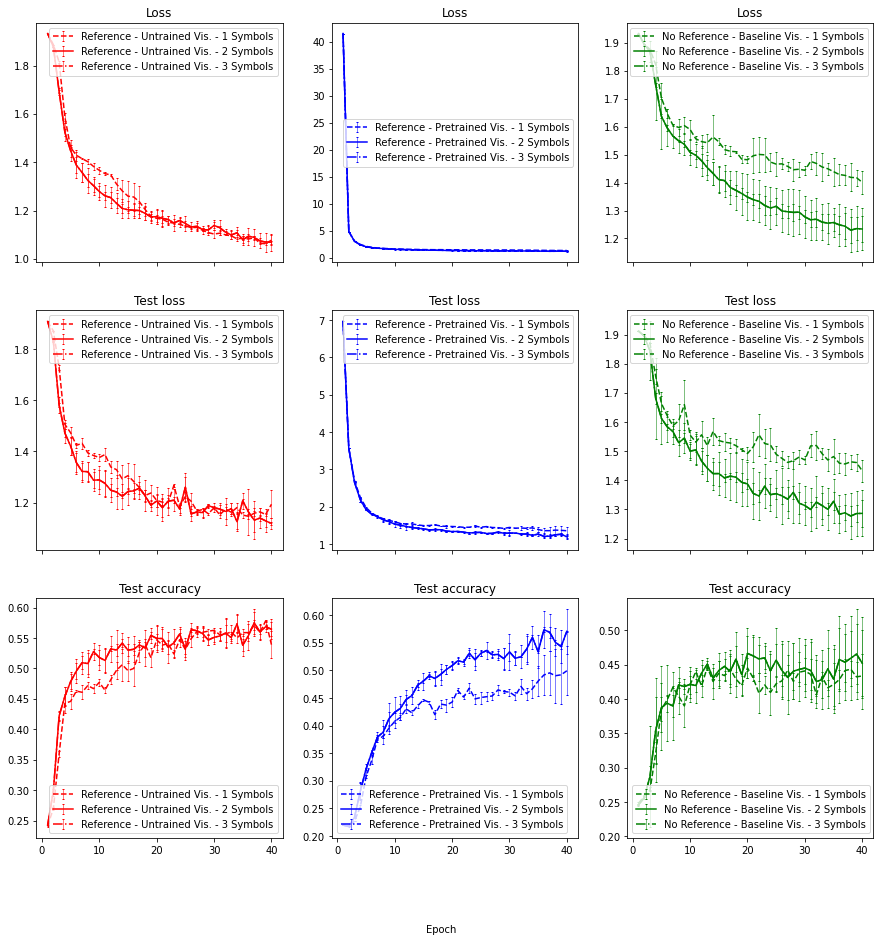

In [21]:
plot_metrics = ["loss", "test_loss", "test_accuracy"]

plot_params = [
  {"game":"basic", "type": "Reference", "game_label": "Untrained", "color":"red"},
  {"game":"att", "type": "Reference", "game_label": "Pretrained", "color":"blue"},
  {"game":"base", "type": "No Reference", "game_label": "Baseline", "color":"green"},
]

f, ax = plt.subplots(len(plot_metrics), len(plot_params), sharex='col', sharey=True if len(plot_metrics) == 1 else False, figsize=(len(plot_metrics) *5 , len(plot_params) * 5))

def label_fnc(r, l, s): 
  return f'{r} - {l} Vis. - {s} Symbols'

for i, m in enumerate(plot_metrics):
  for j, p in enumerate(plot_params):
    x1 = training_df[(training_df["game"] == p["game"]) & (training_df["max_len"] == 2)]["epoch"].unique()
    x2 = training_df[(training_df["game"] == p["game"]) & (training_df["max_len"] == 3)]["epoch"].unique()
    x3 = training_df[(training_df["game"] == p["game"]) & (training_df["max_len"] == 4)]["epoch"].unique()
    # mean
    y_1symb = training_df[(training_df["game"] == p["game"]) & (training_df["max_len"] == 2)].groupby(['epoch'])[m].mean()
    y_2symb = training_df[(training_df["game"] == p["game"]) & (training_df["max_len"] == 3)].groupby(['epoch'])[m].mean()
    y_3symb = training_df[(training_df["game"] == p["game"]) & (training_df["max_len"] == 4)].groupby(['epoch'])[m].mean()
    # std
    std_1symb = training_df[(training_df["game"] == p["game"]) & (training_df["max_len"] == 2)].groupby(['epoch'])[m].std()
    std_2symb = training_df[(training_df["game"] == p["game"]) & (training_df["max_len"] == 3)].groupby(['epoch'])[m].std()
    std_3symb = training_df[(training_df["game"] == p["game"]) & (training_df["max_len"] == 4)].groupby(['epoch'])[m].std()
    
    ax[i][j].errorbar(x1, y_1symb, label=label_fnc(p["type"], p["game_label"], 1), color=p["color"], linestyle='--',
                yerr=std_1symb, elinewidth=0.5, capsize=1)
    ax[i][j].errorbar(x2, y_2symb, label=label_fnc(p["type"], p["game_label"], 2), color=p["color"], linestyle='-',
                yerr=std_2symb, elinewidth=0.5, capsize=1)
    ax[i][j].errorbar(x3, y_2symb, label=label_fnc(p["type"], p["game_label"], 3), color=p["color"], linestyle='-.',
                yerr=std_3symb, elinewidth=0.5, capsize=1)
    ax[i][j].set_title(m.replace("_"," ").capitalize())
    ax[i][j].legend()


f.text(0.5, 0.04, 'Epoch', ha='center', va='center')

plt.show()

## Qualitative analysis

In [22]:
model_path = "models/basic_game6.pt"

game = torch.load(model_path)
game.eval()

SenderReceiverRnnGS(
  (sender): RnnSenderGS(
    (agent): BasicSender(
      (fc): Linear(in_features=64, out_features=20, bias=True)
      (vision): Vision(
        (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
        (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
        (fc1): Linear(in_features=800, out_features=32, bias=True)
      )
    )
    (hidden_to_output): Linear(in_features=20, out_features=4, bias=True)
    (embedding): Linear(in_features=4, out_features=10, bias=True)
    (cell): GRUCell(10, 20)
  )
  (receiver): RnnReceiverGS(
    (agent): BasicReceiver(
      (fc): Linear(in_features=52, out_features=32, bias=True)
      (vision): Vision(
        (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
        (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
        (fc1): Linear(in_features=800, out_features=32, bias=True)
      )
    )
    (cell): GRUCell(10, 20)
    (embedding): Linear(in_features=4, out_features=10, bias=True)
 

In [0]:
def atts2messages(game, target_atts, ref_atts, shape="square"):
  game.eval()
  messages = []
  target_imgs = utils.reconstruct(shape, target_atts).to(device)
  ref_imgs = utils.reconstruct(shape, ref_atts).to(device)
  msgs = game.sender((target_imgs, ref_imgs))
  # print(msgs)
  for i in range(msgs.size(0)):
    messages.append("".join([str(s) for s in (msgs[i]!=0).nonzero()[:,1].tolist()]))
  return messages

def imgs2messages(game, target_imgs, ref_imgs, shape="square"):
  game.eval()
  messages = []
  target_imgs = target_imgs.to(device)
  ref_imgs = ref_imgs.to(device)
  msgs = game.sender((target_imgs, ref_imgs))
  for i in range(msgs.size(0)):
    msg = "".join([str(s) for s in (msgs[i]!=0).nonzero()[:,1].tolist()])
    messages.append(msg)
  return messages

def atts2img(atts, shape="square"):
  return utils.reconstruct(shape, atts).squeeze()

### Data Generation

In [0]:
n_samples=5000

def rand_vals(base, roof):
  return (roof - base) * torch.rand(1) + base

def get_att(x=None, y=None, z=None):
  x = rand_vals(-0.4, 0.4) if x is None else x
  y = rand_vals(-0.4, 0.4) if y is None else y
  z = rand_vals(0.001, 0.05) if z is None else z
  return torch.tensor([[[x, y, z]]]), x, y, z


def get_att_retry(x=None, y=None, z=None):
  att, x, y, z = get_att(x, y, z)
  return att, x, y, z

def get_att_tar_ref(minn, maxx, att, pos=1, x=None, y=None, z=None):
  ref, x, y, z = get_att_retry(None, None, None)
  if att == "x":
    tar, _, _, _ = get_att_retry(x + rand_vals(minn, maxx) * pos, y, z)
  elif att == "y":
    tar, _, _, _ = get_att_retry(x, y + rand_vals(minn, maxx) * pos, z)
  elif att == "z":
    if pos == -1:
      tar, _, _, _ = get_att_retry(x, y, z * rand_vals(1/minn, 1/maxx))
    if pos == 1:
      tar, _, _, _ = get_att_retry(x, y, z * rand_vals(minn, maxx) * pos)
  else:
    tar, _, _, _ = get_att_retry(x + rand_vals(minn, maxx) * pos, y + rand_vals(minn, maxx) * pos, z * rand_vals(minn, maxx) * pos)
  return ref, tar

def get_val_samples(N, settings=None):
  if settings is None:
    settings = {
        "x": [0.1, 0.3],
        "y": [0.1, 0.3],
        "z": [1.0, 3.0]
    }
  x_ref_pos, x_tar_pos = get_att_tar_ref(settings["x"][0], settings["x"][1], att="x", pos=1)
  y_ref_pos, y_tar_pos = get_att_tar_ref(settings["y"][0], settings["y"][1], att="y", pos=1)
  z_ref_pos, z_tar_pos = get_att_tar_ref(settings["z"][0], settings["z"][1], att="z", pos=1)
  x_ref_neg, x_tar_neg = get_att_tar_ref(settings["x"][0], settings["x"][1], att="x", pos=-1)
  y_ref_neg, y_tar_neg = get_att_tar_ref(settings["y"][0], settings["y"][1], att="y", pos=-1)
  z_ref_neg, z_tar_neg = get_att_tar_ref(settings["z"][0], settings["z"][1], att="z", pos=-1)    
  samples = {
      "x_neg_ref": x_ref_neg,
      "x_neg_tar": x_tar_neg,
      "x_pos_ref": x_ref_pos,
      "x_pos_tar": x_tar_pos,
      "y_neg_ref": y_ref_neg,
      "y_neg_tar": y_tar_neg,
      "y_pos_ref": y_ref_pos,
      "y_pos_tar": y_tar_pos,
      "z_neg_ref": z_ref_neg,
      "z_neg_tar": z_tar_neg,
      "z_pos_ref": z_ref_pos,
      "z_pos_tar": z_tar_pos
  }
  for att, minmax in settings.items():
    minn, maxx = minmax
    for n in range(N-1):
      ref, tar = get_att_tar_ref(minn, maxx, att=att, pos=1)
      samples[f"{att}_pos_ref"] = torch.cat((samples[f"{att}_pos_ref"], ref), 0)
      samples[f"{att}_pos_tar"] = torch.cat((samples[f"{att}_pos_tar"], tar), 0)
      ref, tar = get_att_tar_ref(minn, maxx, att=att, pos=-1)
      samples[f"{att}_neg_ref"] = torch.cat((samples[f"{att}_neg_ref"], ref), 0)
      samples[f"{att}_neg_tar"] = torch.cat((samples[f"{att}_neg_tar"], tar), 0)
  return samples
      
samples = get_val_samples(N=n_samples)

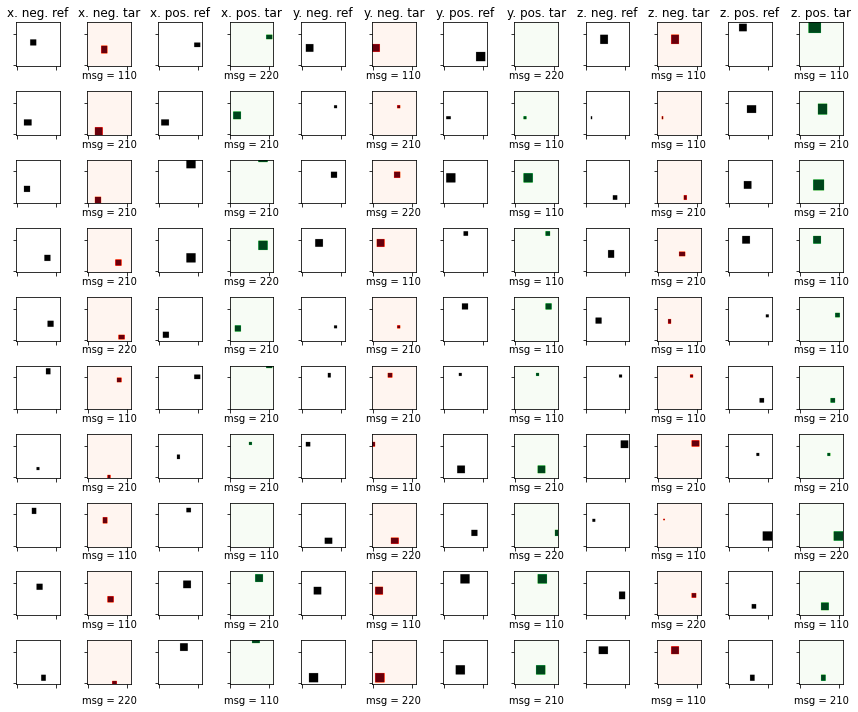

In [25]:
# Data examples

model_path = "models/basic_game6.pt"

game = torch.load(model_path)
game.eval()

n_plot_samples = 10

f, ax = plt.subplots(n_plot_samples, 12, sharex=True, sharey=True, figsize=(12, n_plot_samples))

features = list(samples.keys())

for x in range(n_plot_samples):
  for y, k in enumerate(features):
    with torch.no_grad():
      if "tar" in k:
        tar = samples[k][-1]
      if "pos_tar" in k:
        cmap = plt.get_cmap("Greens")
      elif "neg_tar" in k:
        cmap = plt.get_cmap("Reds")
      else:
        cmap = plt.get_cmap("Greys")
      ax[x][y].imshow(atts2img(samples[k][x].to(device)), cmap=cmap, origin="lower")
      ax[0][y].set_title(f'{k}'.replace('_', '. '))
      ax[x][((y // 2) * 2) + 1].set_xlabel("msg = {}".format(atts2messages(game, samples[features[(y // 2) * 2]][x], samples[features[((y // 2) * 2) + 1]][x])[0]))

      ax[x][y].set_yticklabels([])
      ax[x][y].set_xticklabels([])
      

plt.tight_layout()
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/tensor.py:362: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


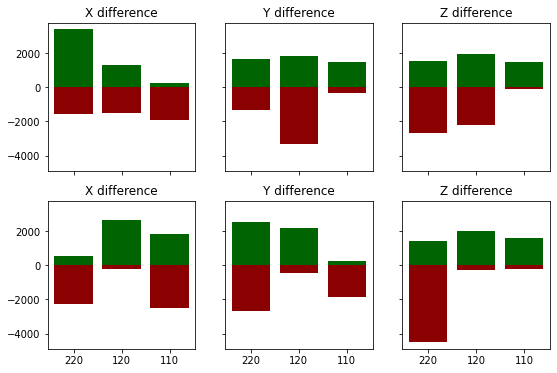

In [26]:
models = ["models/basic_game6.pt", "models/Att_game6.pt"]

f, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(9, 6))

for i, model_path in enumerate(models):

  game = torch.load(model_path)
  game.eval()
  directions = ["x","y","z"]

  msg_samples = {}
  for j, d in enumerate(directions):
    msg_samples[f"{d}_pos"] = atts2messages(game, samples[f"{d}_pos_tar"].resize(n_samples, 3), samples[f"{d}_pos_ref"].resize(n_samples, 3))
    msg_samples[f"{d}_neg"] = atts2messages(game, samples[f"{d}_neg_tar"].resize(n_samples, 3), samples[f"{d}_neg_ref"].resize(n_samples, 3))
  
  df_msg_samples = pd.DataFrame(msg_samples)
  for j, d in enumerate(directions):    
    ax[i][j].bar(x=df_msg_samples[f"{d}_pos"].unique(), height=df_msg_samples.groupby([f"{d}_pos"])[f"{d}_pos"].count(), color="darkgreen")
    ax[i][j].set_title(f"{d} difference".capitalize())
    ax[i][j].bar(x=df_msg_samples[f"{d}_neg"].unique(), height=-df_msg_samples.groupby([f"{d}_neg"])[f"{d}_neg"].count(), color="darkred")
    ax[i][j].set_title(f"{d} difference".capitalize())

##Linear classifier for quantitative analysis

In [0]:
class ProbeNet(nn.Module):
  
  def __init__(self, game, specific=True, multilayer=False, binary=False):
    super(ProbeNet, self).__init__()
    self.game = game
    self.multilayer = multilayer
    self.binary = binary
    if multilayer:
      self.fc = nn.Linear(3*4, 20)
      if specific and not binary:
        self.fc2 = nn.Linear(20, 6)
      elif not binary:
        self.fc2 = nn.Linear(20, 3)
      else:
        self.fc2 = nn.Linear(20, 1)
    elif not binary:
      self.fc = nn.Linear(3*4, 6)
    else:
      self.fc = nn.Linear(3*4, 1)
      
  def forward(self, targets, references):
    messages = self.game.sender((targets, references)).view(-1, 3*4)
    x = self.fc(messages) # which attribute changed and how
    if self.multilayer:
      x = self.fc2(F.relu(x))
    if self.binary:
      x = torch.sigmoid(x)
    return x

In [28]:
# attribute + direction probing:
# GENERAL, so not class specific (not used for paper) 
# show accuracy per attribute + direction during process
# it chooses some classes to optimize for, while ignoring the others

torch.manual_seed(0)

game = torch.load(gameBasic_path)  #switch between game with these lines
# game = torch.load(gameAtt_path)
game.eval()

model = ProbeNet(game, multilayer=False).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-2) 
rand_acc = 0
for epoch in range(20):
  mean_loss, n_batches, accuracy, class_acc = 0, 0, 0, [0,0,0,0,0,0]
  # test_loader: 1 batch = 1 epoch (full batch)
  for i, (target_imgs, target_atts, ref_imgs, _, ref_atts) in enumerate(test6_loader):
      target_imgs, ref_imgs = target_imgs.to(device), ref_imgs.to(device)
      t = atts2classes(target_atts, ref_atts).to(device)

      optimizer.zero_grad()
      output = model(target_imgs, ref_imgs)
      loss = criterion(output, t)
      loss.backward()
      optimizer.step()

      with torch.no_grad():
        correct = torch.argmax(output,1) == t
        rand_correct = torch.randint(6,(t.size(0),)).to(device) == t
        for i in range(6):
          correct_att = correct[t==i]
          class_acc[i] += torch.sum(correct_att).item()/float(torch.sum(t==i))
        accuracy += torch.sum(correct).item()/float(target_imgs.size(0))
        rand_acc += torch.sum(rand_correct).item() / float(target_imgs.size(0))

      mean_loss += loss.mean().item()
      n_batches += 1
  class_acc = [round(acc / n_batches,3) for acc in class_acc]
  print(f'Train Epoch: {epoch}, mean loss: {mean_loss / n_batches}, accuracy: {accuracy / n_batches}, classes: {class_acc}')
print(f"Random: {rand_acc / 20}")

Train Epoch: 0, mean loss: 1.7847963571548462, accuracy: 0.1075, classes: [0.0, 0.087, 0.0, 0.173, 0.389, 0.0]
Train Epoch: 1, mean loss: 1.7338210344314575, accuracy: 0.233, classes: [0.966, 0.0, 0.0, 0.0, 0.389, 0.0]
Train Epoch: 2, mean loss: 1.6916793584823608, accuracy: 0.2465, classes: [0.966, 0.0, 0.477, 0.0, 0.0, 0.0]
Train Epoch: 3, mean loss: 1.6568548679351807, accuracy: 0.2455, classes: [0.0, 0.0, 0.477, 0.0, 0.0, 0.994]
Train Epoch: 4, mean loss: 1.6270520687103271, accuracy: 0.2455, classes: [0.0, 0.0, 0.477, 0.0, 0.0, 0.994]
Train Epoch: 5, mean loss: 1.601054310798645, accuracy: 0.2295, classes: [0.0, 0.0, 0.477, 0.173, 0.0, 0.722]
Train Epoch: 6, mean loss: 1.578924536705017, accuracy: 0.279, classes: [0.0, 0.0, 0.477, 0.0, 0.483, 0.722]
Train Epoch: 7, mean loss: 1.560934066772461, accuracy: 0.2885, classes: [0.751, 0.0, 0.477, 0.0, 0.483, 0.0]
Train Epoch: 8, mean loss: 1.5468080043792725, accuracy: 0.2885, classes: [0.751, 0.0, 0.477, 0.0, 0.483, 0.0]
Train Epoch: 9

In [29]:
# attribute probing: 
# GENERAL, so not class specific (not used for paper) 
# show accuracy per attribute during process

torch.manual_seed(0)

# game = torch.load(gameBasic_path)
game = torch.load(gameAtt_path)
game.eval()


model = ProbeNet(game, specific=False, multilayer=False).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-2) 
rand_acc = 0
for epoch in range(20):
  mean_loss, n_batches, accuracy, class_acc = 0, 0, 0, [0,0,0]
  # test_loader: 1 batch = 1 epoch (full batch)
  for i, (target_imgs, target_atts, ref_imgs, _, ref_atts) in enumerate(test6_loader):
      target_imgs, ref_imgs = target_imgs.to(device), ref_imgs.to(device)
      t = atts2classes(target_atts, ref_atts, specific=False).to(device)

      optimizer.zero_grad()
      output = model(target_imgs, ref_imgs)
      loss = criterion(output, t)
      loss.backward()
      optimizer.step()

      with torch.no_grad():
        correct = torch.argmax(output,1) == t
        rand_correct = torch.randint(3,(t.size(0),)).to(device) == t
        for i in range(3):
          correct_att = correct[t==i]
          class_acc[i] += torch.sum(correct_att).item()/float(torch.sum(t==i))
        accuracy += torch.sum(correct).item()/float(target_imgs.size(0))
        rand_acc += torch.sum(rand_correct).item() / float(target_imgs.size(0))

      mean_loss += loss.mean().item()
      n_batches += 1
  class_acc = [round(acc / n_batches,3) for acc in class_acc]
  print(f'Train Epoch: {epoch}, mean loss: {mean_loss / n_batches}, accuracy: {accuracy / n_batches}, classes: {class_acc}')
print(f"Random: {rand_acc / 20}")

Train Epoch: 0, mean loss: 1.7942692041397095, accuracy: 0.203, classes: [0.0, 0.605, 0.0]
Train Epoch: 1, mean loss: 1.6172258853912354, accuracy: 0.272, classes: [0.011, 0.605, 0.196]
Train Epoch: 2, mean loss: 1.4793363809585571, accuracy: 0.272, classes: [0.011, 0.605, 0.196]
Train Epoch: 3, mean loss: 1.3757848739624023, accuracy: 0.272, classes: [0.011, 0.605, 0.196]
Train Epoch: 4, mean loss: 1.2995961904525757, accuracy: 0.2595, classes: [0.423, 0.161, 0.196]
Train Epoch: 5, mean loss: 1.243970513343811, accuracy: 0.2595, classes: [0.423, 0.161, 0.196]
Train Epoch: 6, mean loss: 1.2032793760299683, accuracy: 0.2595, classes: [0.423, 0.161, 0.196]
Train Epoch: 7, mean loss: 1.173263669013977, accuracy: 0.3255, classes: [0.423, 0.553, 0.0]
Train Epoch: 8, mean loss: 1.150909423828125, accuracy: 0.407, classes: [0.423, 0.392, 0.406]
Train Epoch: 9, mean loss: 1.134158968925476, accuracy: 0.407, classes: [0.423, 0.392, 0.406]
Train Epoch: 10, mean loss: 1.121600866317749, accuracy:

In [30]:
# attribute probing: 
# class specific (used for paper)

torch.manual_seed(0)

Att = 0 #this sets the class to train for (classes explained in atts2classes function)
equalsize = True #it cant find a solution if you set this to False

game = torch.load(gameBasic_path)
# game = torch.load(gameAtt_path)
game.eval()

model = ProbeNet(game, specific=False, multilayer=False, binary=True).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-2) 
rand_acc = 0
for epoch in range(20):
  mean_loss, n_batches, accuracy = 0, 0, 0
  pred0, pred1 = 0, 0 
  # test_loader: 1 batch = 1 epoch (full batch)
  for i, (target_imgs, target_atts, ref_imgs, _, ref_atts) in enumerate(test6_loader):
      target_imgs, ref_imgs = target_imgs.to(device), ref_imgs.to(device)
      t = atts2classes(target_atts, ref_atts, specific=False).type(torch.FloatTensor).to(device)
    
      copy = t.clone()
      t[copy!=Att] = 0
      t[copy==Att] = 1
      if equalsize:
        sumt0 = torch.sum(t==0)
        sample0 = torch.randperm(sumt0)[:torch.sum(t==1)]
        target_imgs = torch.cat((target_imgs[t==0][sample0], target_imgs[t==1]), 0)
        ref_imgs = torch.cat((ref_imgs[t==0][sample0], ref_imgs[t==1]), 0)
        target_atts = torch.cat((target_atts[t==0][sample0], target_atts[t==1]), 0)
        ref_atts = torch.cat((ref_atts[t==0][sample0], ref_atts[t==1]), 0)
        
        t = atts2classes(target_atts, ref_atts, specific=False).type(torch.FloatTensor).to(device)
      
        copy = t.clone()
        t[copy!=Att] = 0
        t[copy==Att] = 1

      optimizer.zero_grad()
      output = model(target_imgs, ref_imgs).squeeze()
      loss = criterion(output, t)
      loss.backward()
      optimizer.step()

      with torch.no_grad():
        rand_correct = torch.randint(2,(t.size(0),)).to(device) == t
        correct = torch.round(output) == t
        accuracy += torch.sum(correct).item()/float(target_imgs.size(0))
        rand_acc += torch.sum(rand_correct).item() / float(target_imgs.size(0))

      mean_loss += loss.mean().item()
      n_batches += 1
      pred0 += torch.sum(torch.round(output)==0).item()
      pred1 += torch.sum(torch.round(output)==1).item()
  print(f'Train Epoch: {epoch}, mean loss: {mean_loss / n_batches}, accuracy: {accuracy / n_batches}')
print(pred0, pred1)
print(f"Random: {rand_acc / 20}")

Train Epoch: 0, mean loss: 0.703918993473053, accuracy: 0.5
Train Epoch: 1, mean loss: 0.6998224258422852, accuracy: 0.48942598187311176
Train Epoch: 2, mean loss: 0.6991222500801086, accuracy: 0.48489425981873113
Train Epoch: 3, mean loss: 0.6967264413833618, accuracy: 0.493202416918429
Train Epoch: 4, mean loss: 0.6956028342247009, accuracy: 0.486404833836858
Train Epoch: 5, mean loss: 0.6947053074836731, accuracy: 0.4901812688821752
Train Epoch: 6, mean loss: 0.6951707005500793, accuracy: 0.48413897280966767
Train Epoch: 7, mean loss: 0.6942103505134583, accuracy: 0.5166163141993958
Train Epoch: 8, mean loss: 0.6952243447303772, accuracy: 0.506797583081571
Train Epoch: 9, mean loss: 0.6943632960319519, accuracy: 0.5090634441087614
Train Epoch: 10, mean loss: 0.6932597160339355, accuracy: 0.5120845921450151
Train Epoch: 11, mean loss: 0.6923920512199402, accuracy: 0.5173716012084593
Train Epoch: 12, mean loss: 0.6936549544334412, accuracy: 0.5045317220543807
Train Epoch: 13, mean los

In [31]:
# attribute + directionprobing:
# class specific (used for paper)

torch.manual_seed(0)

Attdir = 3 #this sets the class to train for (classes explained in atts2classes function)
equalsize = True

# game = torch.load(gameBasic_path)
game = torch.load(gameAtt_path)
game.eval()

model = ProbeNet(game, specific=True, multilayer=False, binary=True).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-2) 
rand_acc = 0
for epoch in range(20):
  mean_loss, n_batches, accuracy = 0, 0, 0
  pred0, pred1 = 0, 0 
  # test_loader: 1 batch = 1 epoch (full batch)
  for i, (target_imgs, target_atts, ref_imgs, _, ref_atts) in enumerate(test6_loader):
      target_imgs, ref_imgs = target_imgs.to(device), ref_imgs.to(device)
      t = atts2classes(target_atts, ref_atts, specific=True).type(torch.FloatTensor).to(device)
    
      copy = t.clone()
      t[copy!=Attdir] = 0
      t[copy==Attdir] = 1
      if equalsize:
        sumt0 = torch.sum(t==0)
        sample0 = torch.randperm(sumt0)[:torch.sum(t==1)]
        target_imgs = torch.cat((target_imgs[t==0][sample0], target_imgs[t==1]), 0)
        ref_imgs = torch.cat((ref_imgs[t==0][sample0], ref_imgs[t==1]), 0)
        target_atts = torch.cat((target_atts[t==0][sample0], target_atts[t==1]), 0)
        ref_atts = torch.cat((ref_atts[t==0][sample0], ref_atts[t==1]), 0)
        
        t = atts2classes(target_atts, ref_atts, specific=True).type(torch.FloatTensor).to(device)
      
        copy = t.clone()
        t[copy!=Attdir] = 0
        t[copy==Attdir] = 1

      optimizer.zero_grad()
      output = model(target_imgs, ref_imgs).squeeze()
      loss = criterion(output, t)
      loss.backward()
      optimizer.step()

      with torch.no_grad():
        rand_correct = torch.randint(2,(t.size(0),)).to(device) == t
        correct = torch.round(output) == t
        accuracy += torch.sum(correct).item()/float(target_imgs.size(0))
        rand_acc += torch.sum(rand_correct).item() / float(target_imgs.size(0))

      mean_loss += loss.mean().item()
      n_batches += 1
      pred0 += torch.sum(torch.round(output)==0).item()
      pred1 += torch.sum(torch.round(output)==1).item()
  
  print(f'Train Epoch: {epoch}, mean loss: {mean_loss / n_batches}, accuracy: {accuracy / n_batches}')
print(pred0, pred1)
print(f"Random: {rand_acc / 20}")

Train Epoch: 0, mean loss: 0.7663987278938293, accuracy: 0.5
Train Epoch: 1, mean loss: 0.7310200929641724, accuracy: 0.5
Train Epoch: 2, mean loss: 0.7020336389541626, accuracy: 0.49277456647398843
Train Epoch: 3, mean loss: 0.6768319010734558, accuracy: 0.7601156069364162
Train Epoch: 4, mean loss: 0.6608678698539734, accuracy: 0.7254335260115607
Train Epoch: 5, mean loss: 0.6472584009170532, accuracy: 0.7210982658959537
Train Epoch: 6, mean loss: 0.6310796737670898, accuracy: 0.7312138728323699
Train Epoch: 7, mean loss: 0.6166067123413086, accuracy: 0.7369942196531792
Train Epoch: 8, mean loss: 0.6088652014732361, accuracy: 0.7283236994219653
Train Epoch: 9, mean loss: 0.5947999954223633, accuracy: 0.7384393063583815
Train Epoch: 10, mean loss: 0.5867179036140442, accuracy: 0.7326589595375722
Train Epoch: 11, mean loss: 0.5862497687339783, accuracy: 0.7196531791907514
Train Epoch: 12, mean loss: 0.5746618509292603, accuracy: 0.726878612716763
Train Epoch: 13, mean loss: 0.569079279

In [0]:
#not sure whether these were used, or if they're going to be used later

def atts2messages(game, target_atts, ref_atts, shape="square"):
  game.eval()
  messages = []
  target_imgs = utils.reconstruct(shape, target_atts).to(device)
  ref_imgs = utils.reconstruct(shape, ref_atts).to(device)
  msgs = game.sender((target_imgs, ref_imgs))
  # print(msgs)
  for i in range(msgs.size(0)):
    messages.append("".join([str(s) for s in (msgs[i]!=0).nonzero()[:,1].tolist()]))
  return messages

def imgs2messages(game, target_imgs, ref_imgs, shape="square"):
  game.eval()
  messages = []
  target_imgs = target_imgs.to(device)
  ref_imgs = ref_imgs.to(device)
  msgs = game.sender((target_imgs, ref_imgs))
  for i in range(msgs.size(0)):
    msg = "".join([str(s) for s in (msgs[i]!=0).nonzero()[:,1].tolist()])
    messages.append(msg)
  return messages

def atts2img(atts, shape="square"):
  return utils.reconstruct(shape, atts).squeeze()